In [1]:
!date
!python --version

Fri May  2 12:44:12 AM UTC 2025
Python 3.11.12


更新履歴
- 2025年5月1日
  - 解説追加。
  - TrainingArguments
    - evaluation_strategyをeval_strategyに変更。
    - `report_to="none"`を追加。（デフォルトだとwandbを使うため、APIキー入力待ちになってしまう）

# AutoModelForSequenceClassificationを用いたファインチューニング例
このノートブックでは[Japanese Realistic Textual Entailment Corpus](https://github.com/megagonlabs/jrte-corpus)のpn.tsvをデータセットとし、BERT（"tohoku-nlp/bert-base-japanese-v3"）を用いてファインチューニングする例を示している。

pn.tsvは実際のレビュー文に対して5名の被験者が極性ラベルを付与したデータセットである。[上記サイトのデータ説明](https://github.com/megagonlabs/jrte-corpus?tab=readme-ov-file#datapntsv)にあるとおり、ID, Label, Text, Judges, Usage の5列のデータがサンプル毎に用意されている。
- ID: ユニークなID
- Label: 1 (Positive), 0 (Neutral), -1 (Negative)
- Text: レビュー文そのもの
- Judges: JSONフォーマットによる極性判定結果。例: `{"0": 1, "1": 4}`
- Usage: train, deve, testの種別。

全体の流れは以下の通り。

- 環境構築: fugashi, accelerateをインストール
- モジュール読み込み
- データ前処理: LLMにおける分類タスクでは教師ラベルを「0から始まる整数」として割り振る必要があるため、ラベルを設定し直した。
- モデルの用意: tokenizerの動作確認を含む。
- LLM用にデータを整形: tokenizerの出力と教師ラベルを合わせてDataset型に変換。
- 学習
- テストデータに対する詳細結果
- 学習データに対する詳細結果

In [15]:
!curl -O https://raw.githubusercontent.com/megagonlabs/jrte-corpus/refs/heads/master/data/pn.tsv
!head pn.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  473k  100  473k    0     0  1275k      0 --:--:-- --:--:-- --:--:-- 1275k
pn17q00001	0	出張でお世話になりました。	{"0": 3}	test
pn17q00002	0	朝食は普通でした。	{"0": 3}	test
pn17q00003	1	また是非行きたいです。	{"1": 3}	test
pn17q00004	1	また利用したいと思えるホテルでした。	{"1": 3}	test
pn17q00005	1	駅から近くて便利でした。	{"0": 1, "1": 2}	test
pn17q00006	1	また来年も利用したいと思います。	{"0": 1, "1": 2}	test
pn17q00007	0	新婚旅行で利用しました。	{"0": 3}	test
pn17q00008	1	また利用いたします。	{"0": 1, "1": 2}	test
pn17q00009	1	コストパフォーマンス最高です。	{"1": 3}	test
pn17q00010	0	お心遣いありがとうございました。	{"0": 2, "1": 1}	test


## 注意
### GPUを指定する
LLMを用いた学習を行っている都合上、デフォルト（CPU）実行すると極めて時間がかかる。おそらく数時間要するだろう。自身でも動作確認したい人は、GPUを指定して実行することをお勧めする。

GPUを指定するには以下の手順を取る。
- 「ランタイム」から「ランタイムのタイプの変更」を選ぶ。
- 「ハードウェア アクセラレータ」からGPUを選ぶ。
  - T4 GPU を選ぶと良い。この中では低スペックだが十分早い。T4 GPUなら、10エポックの学習が約14分で終了する。

### リソース使用制限
Google Colabは無料で利用できるが、利用度合いに応じてリソースが制限されることがある。特にGPUは使えなくなることが多いため、不必要に何度も実行することは避けよう。

詳細: [最適な Colab のプランを選択する](https://colab.research.google.com/signup/pricing?hl=ja)

### 必要に応じてモデルや結果をファイル保存する
このノートブックではノートブック内に出力しつつ、学習したモデルはセッション内に保存しているだけで終えている。このため後日「学習結果を利用したい」場合には改めて学習し直す必要がある。それが面倒に思う人はファイル保存するようにしよう。

なお、正確には「ファイル」ではなく「複数のファイルを含むフォルダ」として保存されている。このフォルダ単位でダウンロードしたり、アップロードしてモデルを復元する必要があることに注意しよう。

またモデルはとてもファイルサイズが大きく、実際にダウンロード＆アップロードするにはとても時間がかかる。そのためGoogleドライブにアクセス許可した上で自身のドライブ内に保存する方が楽だ。

```Python
# ノートブックからドライブへのアクセスを許可する
from google.colab import drive
drive.mount('/content/drive')
```

## 環境構築

In [3]:
!pip install fugashi[unidic-lite]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.0/698.0 kB 5.4 MB/s eta 0:00:00
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658817 sha256=dbcb89f589c4f364e62826e9552de412a0e688f737d11c42dde9f26283941cb3
  Stored in directory: /root/.cache/pip/wheels/b7/fd/e9/ea4459b868e6d2902e8d80e82dbacb6203e05b3b3a58c64966
Successfully built unidic-lite
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

## モジュール読み込み、データ前処理
元データでは極性が -1, 0, 1 で付与されている。しかし教師ラベルとしては0から始まる整数で設定する必要がある。そのためここでは read_csv() で読み込んだ後、map関数により -1を0に、0を1に、1を2に置換している。

In [4]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# データの読み込み
filename = "pn.tsv"
columns = ["id", "sentiment", "text", "judges-json", "usage"]
df = pd.read_csv(filename, sep="\t", names=columns)
df.head()

,id,sentiment,text,judges-json,usage
0,pn17q00001,0,出張でお世話になりました。,"{""0"": 3}",test
1,pn17q00002,0,朝食は普通でした。,"{""0"": 3}",test
2,pn17q00003,1,また是非行きたいです。,"{""1"": 3}",test
3,pn17q00004,1,また利用したいと思えるホテルでした。,"{""1"": 3}",test
4,pn17q00005,1,駅から近くて便利でした。,"{""0"": 1, ""1"": 2}",test


In [5]:
# ラベルの付け替え
# AutoModelForSequenceClassificationではラベルは「0から始まる整数」である必要がある。
# このため -1, 0, 1 => 0, 1, 2（ネガティブ0、ノーマル1、ポジティブ2）に付け替える。
df['sentiment'] = df['sentiment'].map({-1: 0, 0: 1, 1: 2})
df.head()

,id,sentiment,text,judges-json,usage
0,pn17q00001,1,出張でお世話になりました。,"{""0"": 3}",test
1,pn17q00002,1,朝食は普通でした。,"{""0"": 3}",test
2,pn17q00003,2,また是非行きたいです。,"{""1"": 3}",test
3,pn17q00004,2,また利用したいと思えるホテルでした。,"{""1"": 3}",test
4,pn17q00005,2,駅から近くて便利でした。,"{""0"": 1, ""1"": 2}",test


In [6]:
# データセットの分割
train_texts = df[df["usage"] == "train"]["text"].tolist()
train_labels = df[df["usage"] == "train"]["sentiment"].tolist()
dev_texts = df[df["usage"] == "dev"]["text"].tolist()
dev_labels = df[df["usage"] == "dev"]["sentiment"].tolist()
test_texts = df[df["usage"] == "test"]["text"].tolist()
test_labels = df[df["usage"] == "test"]["sentiment"].tolist()

# 動作確認
print(f"{train_texts[0]=}")
print(f"{train_labels[0]=}")
print(df['sentiment'].value_counts())

train_texts[0]='(笑)'
train_labels[0]=1
sentiment
2    3406
1    1329
0     818
Name: count, dtype: int64


## モデルの用意
- ここでは "tohoku-nlp/bert-base-japanese-v3" を利用。
- 長文だが、最初の出力「`Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tohoku-nlp/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']   You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.`」は、このままでは利用できない（ので学習が必要だろう）ということを指摘している。この理由は、AutoModelForSequenceClassificationが「LLMの最後尾に新たな線形層（[torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)）を追加しているためだ。この線形層はクラス数と同数のユニットを持つように設定されており（引数num_labelsで設定）、各ユニットに対するスコアを求めるようにモデルを拡張している。
- このようなにモデルを拡張しているということは、拡張した部分（Linear層のパラメータ）については重みがまっさらな状態である。このままでは当然推定できない（でたらめになる）ため、「You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.」と注意を促している。

In [7]:
# ハイパーパラメータ
num_labels = 3   # クラス数
max_length = 128 # 最長系列長（最大トークン数）
num_train_epochs = 10 # 最大学習エポック数
output_dir = './results' # チェックポイント等を保存するディレクトリ
batch_size = 16  # バッチサイズ（一度に処理するサンプル数）
logging_dir = './logs' # ログ出力用のディレクトリ（主にエラー確認用）

# トークナイザーとモデルの準備
model_name = "tohoku-nlp/bert-base-japanese-v3"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# データセットのトークナイズ
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
dev_encodings = tokenizer(dev_texts, truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

# 動作確認
# 'input_ids', 'token_type_ids', 'attention_mask'をキーとするリストとして保存されている。
# ['input_ids'][0] は、0番目のみを出力指定。
print(train_encodings.keys())
print(train_encodings['input_ids'][0]) # サンプル0番目
print(train_encodings['attention_mask'][0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/447M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tohoku-nlp/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/447M [00:00<?, ?B/s]

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
[2, 23, 4374, 24, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [8]:
# input_ids をデコードして元の文章を確認
tokenizer.decode([2, 23, 4374, 24, 3])

'[CLS] ( 笑 ) [SEP]'

## LLM用にデータを整形
今回は分類タスクとして学習させたい。しかしtokenizerではテキストに対する前処理しか行われておらず、教師ラベルは別に用意している。これらを使いやすい形（Dataset型）にまとめ直している。

print文では、Dataset型の例としてtrain_dataset[0]を出力している。
- トークン系列分用意するデータ（同じ長さで揃える必要がある）
  - `input_ids`: 入力文をトークナイズした結果（トークンのID列）。
  - `tokey_type_ids`: BERT系では2文の対で用意することを前提としている。その2文を区別するためのフィルタ設定。単一文の場合は全て0（今回はこれ）。2文ある場合、文2のトークンは1になる。
  - `attention_mask`: 一般的には「どのトークンに注意を向けるか」を0（無視する）,1（注意を向ける）で設定している。ここでは実トークンがある部分を1に、パディングで意味の無い部分を0として設定している。
- 教師データ
  - `labels`: Trainerと連動した設定。`train_dataset=train_dataset` と設定していると、train_dataset内の"labels"を自動で参照し、損失を計算するようになっている。違う名目でラベルを設定したい場合には DataCollatorもしくはTrainerをカスタマイズする必要があります。

In [9]:
class SentimentDataset(torch.utils.data.Dataset):
    '''サンプル毎に input_ids, token_type_ids, attention_mask, labels を設定。
    '''
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
dev_dataset = SentimentDataset(dev_encodings, dev_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

# 動作確認
# サンプル毎に input_ids, token_type_ids, attention_mask, labels を用意した
print(train_dataset[0])

{'input_ids': tensor([   2,   23, 4374,   24,    3,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_ma

## 学習
エポック毎に出力しているログは、学習データに対する損失(training loss)、検証データに対する損失(validation loss)、正解率(accuracy)、F1スコア(F1)、適合率(precision)、再現率(recall)。

ログを確認すると、基本的には学習データに対する損失は減り続けている。しかし検証データに対する損失は途中から「逆に増えている」ことを確認できる。これが[過学習（過剰適合; over-fitting）](https://en.wikipedia.org/wiki/Overfitting#Machine_learning)だ。ここでは特別なことはせずに指定したエポック数の学習を続け、最終モデルを用いた検証を行うこととした。

- TrainingArgumentsで用いているパラメータ
- TrainingArgumentsの補足
  - 設定可能な項目多数のため、詳細は[huggingfaceの公式ドキュメント](https://huggingface.co/docs/transformers/ja/main_classes/trainer)推奨。ここでは利用したパラメータだけ説明する。
  - `output_dir`: チェックポイント（学習済みモデル）やログを保存する出力先ディレクトリを指定。
    - チェックポイントとは、別のパラメータ「save_strategy = "epoch"」として指定したタイミングのモデルのこと。今回はepochと指定しているため1エポック毎にモデルが保存されている。
    - 必要に応じてこれらのチェックポイントからモデルを復元することも可能。モデル読み込み時にファイルを指定するだけで良い。このためファインチューニングしたモデルをファイル保存しておきたいならば、resultsフォルダ内のチェックポイントを保存しておくか、最終モデルである sentiment_model を保存しておくと良いだろう。
    - ダウンロードするというよりは、Googleドライブへのアクセス許可を与え、自身のドライブ内に保存する方が良いだろう。
  - `num_train_epochs`: 学習を繰り返すエポック数。1エポックは全データを1周すること。
  - `per_device_train_batch_size`: 学習時に1デバイス（GPU/CPU）あたりで処理するバッチサイズ。
  - `per_device_eval_batch_size`: 評価時のバッチサイズ。
  - `warmup_steps`: 指定した初期ステップ数（〜500ステップまで）は学習率を徐々に増やす。デフォルトでは0から指定した学習率まで線形単調増加。
  - `weight_decay`: L2正則化による過学習抑制のための調整項。
  - `logging_dir`: TensorBoard用ログの出力先。
  - `logging_steps`: 指定ステップ毎に損失などのログを記録。
  - `eval_strategy`: 評価を行うタイミング（今回は1エポック終了毎）。
  - `save_strategy`: モデル保存タイミング。
  - `report_to`: 学習をどこに送るか。今回は外部ログ連携無し。

In [10]:
# トレーニングの設定
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=logging_dir,
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    report_to="none" # wandbを使わない
)

# 精度の計算
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average='macro')
    acc = accuracy_score(labels, pred)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# トレーナーの設定
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics
)

# モデルのトレーニング
trainer.train()

# モデルの保存
trainer.save_model("./sentiment_model")

# テストセットでの評価
results = trainer.evaluate(eval_dataset=test_dataset)

# 結果の表示
print(f"Test Accuracy: {results['eval_accuracy']}")
print(f"Test F1 Score: {results['eval_f1']}")
print(f"Test Precision: {results['eval_precision']}")
print(f"Test Recall: {results['eval_recall']}")

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.404300,0.408381,0.847122,0.792012,0.821642,0.776139
2,0.290400,0.370082,0.859712,0.815932,0.820656,0.811538
3,0.196200,0.432191,0.877698,0.838691,0.845239,0.837207
4,0.151200,0.478974,0.884892,0.844025,0.846112,0.845028
5,0.079300,0.555178,0.871403,0.831201,0.832901,0.829776
6,0.052700,0.722724,0.863309,0.824431,0.823894,0.826944
7,0.001300,0.758387,0.875000,0.831257,0.835224,0.829333
8,0.023000,0.835225,0.875899,0.828396,0.838685,0.821027
9,0.000300,0.864122,0.875899,0.831851,0.837495,0.826545
10,0.000600,0.866264,0.875899,0.831269,0.838046,0.824955


Test Accuracy: 0.8553345388788427
Test F1 Score: 0.8221032582050153
Test Precision: 0.8452179386146287
Test Recall: 0.8034550381672684


## テストデータに対する詳細結果

In [11]:
# テストデータに対する詳細結果
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
#import numpy as np

predictions, labels, _ = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)
labels = ['negative', 'normal', 'positive']

# 分類レポートの表示
print(classification_report(test_labels, predicted_labels, target_names=labels))

              precision    recall  f1-score   support

    negative       0.91      0.79      0.85        78
      normal       0.74      0.67      0.70       139
    positive       0.89      0.95      0.92       336

    accuracy                           0.86       553
   macro avg       0.85      0.80      0.82       553
weighted avg       0.85      0.86      0.85       553



Text(0.5, 1.0, 'Confusion Matrix')

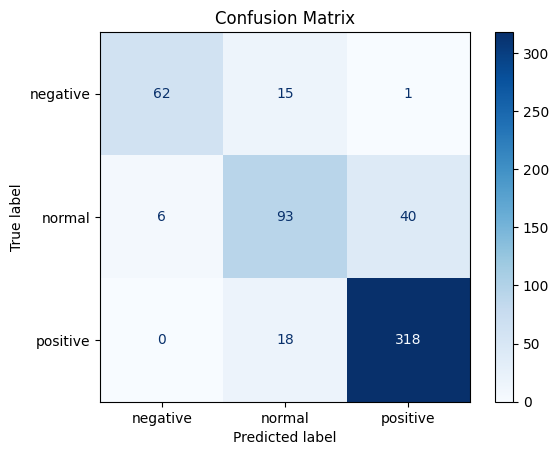

In [12]:
# 混同行列の表示
conf_matrix = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')

## 具体的な失敗例
ラベルは「ネガティブ0、ノーマル1、ポジティブ2」に付け直していることに注意。

### 学習データに対する誤り
以下の通り1件しか誤りがない。学習データに対しては極めて的鉄な予測が可能なモデルになっているようだ。

In [13]:
# 学習データに対する予測誤り

predictions, labels, _ = trainer.predict(train_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# 誤った予測のサンプルを抽出
incorrect_indices = [i for i, (true, pred) in enumerate(zip(train_labels, predicted_labels)) if true != pred]

# 誤った予測のサンプルを出力
for i in incorrect_indices:
    print(f"正解ラベル: {train_labels[i]}, 予測ラベル: {predicted_labels[i]}, テキスト: {train_texts[i]}")

正解ラベル: 2, 予測ラベル: 1, テキスト: 家族旅行で利用させていただきました。
正解ラベル: 2, 予測ラベル: 1, テキスト: 東京出張時に利用しました。


### テストデータに対する誤り
テストデータのサンプル数は学習データより少ないにも関わらず、失敗事例数は多い。

In [14]:
# テストデータに対する予測誤り

predictions, labels, _ = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# 誤った予測のサンプルを抽出
incorrect_indices = [i for i, (true, pred) in enumerate(zip(test_labels, predicted_labels)) if true != pred]

# 誤った予測のサンプルを出力
for i in incorrect_indices:
    print(f"正解ラベル: {test_labels[i]}, 予測ラベル: {predicted_labels[i]}, テキスト: {test_texts[i]}")

正解ラベル: 1, 予測ラベル: 2, テキスト: お心遣いありがとうございました。
正解ラベル: 0, 予測ラベル: 1, テキスト: と感じてしまいました。
正解ラベル: 2, 予測ラベル: 1, テキスト: 再訪です。
正解ラベル: 2, 予測ラベル: 1, テキスト: 二度目です。
正解ラベル: 1, 予測ラベル: 2, テキスト: お疲れ様です。
正解ラベル: 1, 予測ラベル: 2, テキスト: (^ω^
正解ラベル: 1, 予測ラベル: 2, テキスト: 対応ありがとうございました。
正解ラベル: 2, 予測ラベル: 1, テキスト: 加湿器もありました。
正解ラベル: 1, 予測ラベル: 2, テキスト: コンビニも近かったです。
正解ラベル: 1, 予測ラベル: 2, テキスト: 長々と失礼しました。
正解ラベル: 2, 予測ラベル: 1, テキスト: 定宿にします。
正解ラベル: 0, 予測ラベル: 1, テキスト: 朝食は食べませんでした。
正解ラベル: 1, 予測ラベル: 2, テキスト: 良かった所。
正解ラベル: 1, 予測ラベル: 2, テキスト: お待ちしておりました。
正解ラベル: 1, 予測ラベル: 2, テキスト: 思わず笑ってしまいました。
正解ラベル: 1, 予測ラベル: 2, テキスト: 大人の宿です。
正解ラベル: 2, 予測ラベル: 1, テキスト: 間違いないホテルです。
正解ラベル: 2, 予測ラベル: 1, テキスト: 迷わず予約しました。
正解ラベル: 1, 予測ラベル: 2, テキスト: 足湯もありました。
正解ラベル: 0, 予測ラベル: 1, テキスト: おかしいです。
正解ラベル: 1, 予測ラベル: 2, テキスト: 料理は期待通りでした。
正解ラベル: 1, 予測ラベル: 0, テキスト: 好みの問題ですが。
正解ラベル: 1, 予測ラベル: 0, テキスト: リゾートホテルではありません。
正解ラベル: 1, 予測ラベル: 2, テキスト: また機会があれば...。
正解ラベル: 1, 予測ラベル: 2, テキスト: 朝食付きをお勧めします。
正解ラベル: 2, 予測ラベル: 1, テキスト: そんなに気になりませんでした。
正解ラベル: 2, 予測ラベル: 1, テキスト: 立地は問題なしです。